Health.ipynb allows to build the dataframe linking each product id to its corresponding nutrients: it is stored under the name of products_with_link_to_nutrients_df.pickle

### Remarks / TODO:
    -there are a few food items in MISC. TRANS
    -add the nutrients present under different names and ids, such as: carbohydrates or carbohydrates by difference

In [1]:
%matplotlib inline
import re
import os
import nltk
import time
import pickle
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from IPython.core.display import SVG

sys.path.insert(1, './utilities/')
from health_functions import *
%load_ext autoreload
%autoreload 2

In [2]:
DUNNHUMBY_PATH = '../data/dunnhumby - The Complete Journey CSV/'
HEALTH_PATH = '../data/health'

## Import Data

In [3]:
def import_data(path1, path2):
    # Dunnhumby data
    dfList = {}
    for r, d, f in os.walk(path1):
        for file in f:
            if '.csv' in file:
                print(file)
                dfList[file] = pd.read_csv(os.path.join(r, file))

    products_df = dfList['product.csv']
    transaction_data_df = dfList['transaction_data.csv']
    hh_demographic_df = dfList['hh_demographic.csv']

    # Nutrients data
    dfList = {}
    for r, d, f in os.walk(path2):
        for file in f:
            if '.csv' in file:
                # print(file)
                dfList[file] = pd.read_csv(os.path.join(r, file))

    # link the nutrient id with its name
    nutrient_df = dfList['nutrient.csv']
    # contains the food articles name and their id test commit
    food_df = dfList['food.csv']
    # contains the nutrients for each food article
    food_nutrients_df = dfList['food_nutrient.csv']
    # linke the food articles ids to their category
    food_category_df = dfList['food_category.csv']
    return products_df,transaction_data_df, nutrient_df, food_df, food_nutrients_df, food_category_df, hh_demographic_df


products_df,transaction_data_df, nutrient_df, food_df, food_nutrients_df, food_category_df, hh_demographic_df = import_data(DUNNHUMBY_PATH, HEALTH_PATH)


coupon_redempt.csv
hh_demographic.csv
causal_data.csv
product.csv
coupon.csv
campaign_desc.csv
campaign_table.csv
transaction_data.csv


/home/ymentha/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Dunnhumby Data

We treat exclusively the dunnhumby products that have been sold at leats 1000 times and that are food-related: the columns "COMMODITY_DESC" and "SUB_COMMODITY_DESC" are used as the source of information for the ingredients of the product and assembled in a single parsed column "ingredients"

In [5]:
#select all the items sold at least 1000 times
sales_qte_df = transaction_data_df[['PRODUCT_ID','QUANTITY']]\
    .groupby(['PRODUCT_ID']).sum().sort_values(by=['QUANTITY'],ascending=False)
sales_qte_df = sales_qte_df[sales_qte_df['QUANTITY'] > 1000]

#select only the categories which are food related, join them with the >1000 sold items and sort them
food_related = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT'])

products_sales_df = products_df.loc[(products_df['DEPARTMENT'].isin(food_related))].join(sales_qte_df, on='PRODUCT_ID', how='inner')
products_sales_df.sort_values(by='QUANTITY',ascending=False,inplace=True)

We put all the description in an "ingredients" column

In [6]:
products_sales_df['ingredients'] = products_sales_df.COMMODITY_DESC + " " + products_sales_df.SUB_COMMODITY_DESC
products_sales_df.drop(["DEPARTMENT","BRAND","COMMODITY_DESC","SUB_COMMODITY_DESC"],axis = 1, inplace = True)

products_sales_df.ingredients = products_sales_df.ingredients.apply(parse_words)

In [8]:
products_sales_df.ingredients.head()

35576    [tropical, fruit, bananas]
25754              [milk, products]
29657              [milk, products]
41175              [milk, products]
38262              [milk, products]
Name: ingredients, dtype: object

The resulting schema of products_sales_df looks as follows:

In [9]:
products_sales_df.head(3)

,PRODUCT_ID,MANUFACTURER,CURR_SIZE_OF_PRODUCT,QUANTITY,ingredients
35576,1082185,2,40 LB,30896,"[tropical, fruit, bananas]"
25754,995242,69,,21758,"[milk, products]"
29657,1029743,69,1 GA,16976,"[milk, products]"


## Downloaded food nutrients data

* The description of food_df gets parsed inplace in order to get a list of words
* The food_nutrients_df gets processed such that we have the fdc_id vs the nutriments as columns (by joining it with nutrient_df)

In [12]:
#drop unnecessary columns and rename to be more understandable
food_nutrients_df.drop(["data_points","min","max","median","footnote","min_year_acquired","derivation_id"]\
                       ,axis=1,inplace=True)
nutrient_df.drop(["nutrient_nbr","rank"],axis=1,inplace=True)
food_category_df.drop(["code"],axis=1,inplace=True)
food_df.drop(["publication_date"],axis=1,inplace=True)

food_category_df.rename(columns={'id':'food_category_id','description':'category'},inplace= True)

#filter out only the necessary food nutrients since we have 227, 
#a lot of which aren't necessary to determine if a food is healthy
list_relevant_nutrients = ["Protein", "Total Carbohydrate","Total lipid (fat)","Sucrose",\
                            "Glucose (dextrose)","Sugars, total including NLEA","Fatty acids, total monounsaturated",\
                            "Fatty acids, total polyunsaturated","Fatty acids, total trans",\
                           "Fatty acids, total saturated","Cholesterol","Vitamin E, added",\
                           "Vitamin K (phylloquinone)","Vitamin B-12","Vitamin B-6",\
                            "Vitamin D","Vitamin A, RAE","Sodium, Na","Total fat (NLEA)","Fiber, total dietary",\
                           "Energy","Carbohydrate, by summation","Fructose"]

nutrient_df = nutrient_df[nutrient_df.name.isin(list_relevant_nutrients)]

#simplify and normalize the nutrient names
simplified_names = nutrient_df.name.apply(trim_nutrient_name)
nutrient_df.loc[:,"name"] = simplified_names

#add the names of the nutrients contained in the food
food_nutrients_df = food_nutrients_df.join(nutrient_df.set_index('id'),on='nutrient_id',how='inner')

#energy is duplicated because we have both kcal and kj, we take only kcal
food_nutrients_df = food_nutrients_df.pivot_table(index='fdc_id', columns='name', values='amount',aggfunc='first')
food_nutrients_df.fillna(value=0, inplace=True)
food_nutrients_df.reset_index(inplace = True)

#add categories to the food df
food_df = food_df.join(food_category_df.set_index("food_category_id"),on="food_category_id",how="left")
food_df.drop(["food_category_id","data_type"],axis=1,inplace=True)
food_df.description = food_df.description.apply(parse_words)

TODO: is the category really useful?? I would drop it Y.

In [30]:
food_df.head()

,fdc_id,description,category
0,336069,"[milk, nfs]",NaN
1,336070,[milk],NaN
2,336071,"[milk, low, sodium]",NaN
3,336072,"[milk, calcium, fortified]",NaN
4,336073,"[milk, calcium, fortified, low, fat]",NaN


In [31]:
food_nutrients_df.head(3)

name,fdc_id,cholesterol,energy,fatty acids total monounsaturated,fatty acids total polyunsaturated,fatty acids total saturated,fiber,protein,sodium,sugars,total lipid,vitamin a,vitamin b-12,vitamin b-6,vitamin e,vitamin k
0,336068,14.0,70.0,1.658,0.497,2.009,0.0,1.03,17.0,6.89,4.38,61.0,0.05,0.011,0.0,0.3
1,336069,7.0,50.0,0.507,0.094,1.154,0.0,3.28,44.0,5.08,1.91,54.0,0.49,0.037,0.0,0.2
2,336070,10.0,61.0,0.812,0.195,1.865,0.0,3.15,43.0,5.05,3.25,46.0,0.45,0.036,0.0,0.3


_At this stage 2 dataframes are useful for what follows:_
- food_name_df = fdc_id vs parsed food title (list of string)
- food_nutrients_df = fdc_id vs nutrients contained as columns

## Word Importance

_We filter the words according to their importance: that is, a word is more important as it apears many times in both datasets: (Ex: 'orange' is more important than 'artificial'). The words occuring in only one dataset are of no importance. The rest of the algorithm follows the pipeline described further._

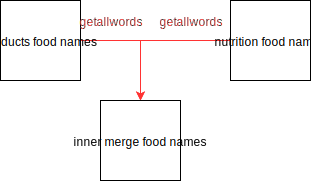

In [32]:
SVG(filename='graphs/allwords.svg')

In [33]:
#all words present in the nutrition dataset
all_words_nutrition = get_allwords(food_df.description)

#all words present in the product dataset
all_words_supermarket = get_allwords(products_sales_df.ingredients)

### Obtaining words importance:

_We check which words occur in both dataframes: only these words will have importance in determining the true nature of the food article we are dealing with. Of course, if no words are known from the nutrition dataset, the sample is not taken into account._


In [34]:
common_words = pd.merge(all_words_supermarket,all_words_nutrition,left_on = 'name',right_on = 'name',suffixes=('_supermarket', '_nutrition'))

In [35]:
print("Number of common words:{}".format(common_words.size))
common_words.head(10)

Number of common words:525


,name,number_supermarket,number_nutrition
0,soft,53,66
1,cheese,28,534
2,vegetables,25,458
3,meat,24,398
4,carb,18,2
5,powder,18,164
6,soup,17,244
7,baked,16,449
8,drink,15,155
9,rolls,15,4


Now we have the common words between the 2 datasets and their occurence, we need to construct a dictionary associating an importance score to each of these words _(the details of this score are discribed in the construct_dic_score function)_ 

As an intuitive feeling of the notion of "importance" we are using, consider the following example: in an article "frozen salted spinaches" found in the dunnhumby database, the term "spinach" is more important than "frozen" or "salted" since it is the main component, and would thus have more in common with the nutrient of some "spinach" article of the nutrient database.

In [36]:
DIC_SCORE = construct_dic_score(common_words)

## Application of the function

Now that we have the importance for each food word, we apply the following recursive algorithm, in order to find "matching" articles in the nutrient database for each article of the dunnhumby database.
We create the dataframe top_df wich associates the nutriments to every dunnhumby article

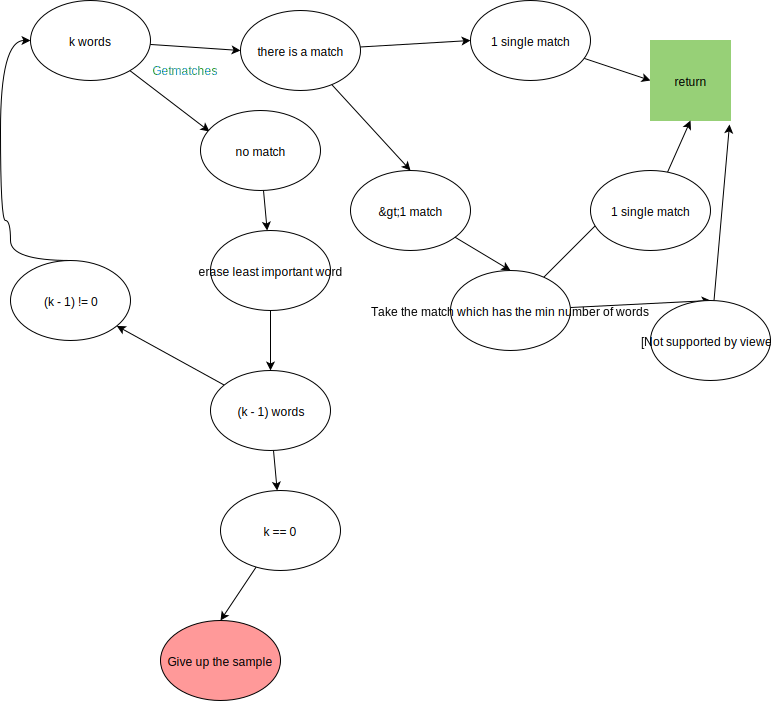

In [37]:
SVG(filename='graphs/Word_importance.svg')

In [38]:
print("Number items to match with the other dataset:{}".format(products_sales_df.size))

Number items to match with the other dataset:1635


In [39]:
# the fdc id is the id of the food articles in the nutriment dataset: ref_fdc_id is the reference that an item of the product dataset needs which poibts on the corresponding article in the nutriment dataset
top_df = products_sales_df.copy()
top_np = top_df.ingredients.to_numpy()
#we take the [1] since the id of the corresponding article is in the second result: the [0] is the name of the corresponding item
top_np_res = np.array([find_food(x,food_df,DIC_SCORE) for x in top_np])
nut_food_names = top_np_res.T[0]
nut_food_ids = top_np_res.T[1]
top_df["ref_fdc_id"]  = nut_food_ids
top_df["ref_fdc_name"] = nut_food_names


In [40]:
top_df.head()

,PRODUCT_ID,MANUFACTURER,CURR_SIZE_OF_PRODUCT,QUANTITY,ingredients,ref_fdc_id,ref_fdc_name
35576,1082185,2,40 LB,30896,"[tropical, fruit, bananas]",341687,"[tropical, fruit, cocktail, cooked, light, syrup]"
25754,995242,69,,21758,"[milk, products]",336070,[milk]
29657,1029743,69,1 GA,16976,"[milk, products]",336070,[milk]
41175,1133018,69,,12318,"[milk, products]",336070,[milk]
38262,1106523,69,1 GA,11500,"[milk, products]",336070,[milk]


In [41]:
top_df = top_df.merge(food_nutrients_df,how="left",left_on="ref_fdc_id",right_on="fdc_id")
top_df.drop(["MANUFACTURER","ref_fdc_id","fdc_id"],axis=1,inplace=True)
top_df.set_index("PRODUCT_ID",inplace=True)

In [42]:
#saves results of this lengthy computation
top_df.to_pickle("../results/products_with_link_to_nutrients_df.pickle")

In [28]:
top_df.index.unique()

Int64Index([ 1082185,   995242,  1029743,  1133018,  1106523,   981760,
             1007195,   883404,   866227,   995785,
            ...
              883003,  5568729,  8065410, 12263788,   839849,  5584007,
             1055283,  1107553,   939636,  9677202],
           dtype='int64', name='PRODUCT_ID', length=327)

We have established the link between the dunnhumby supermarket dataset and the food database from the Department of Food and Agriculture which provides the nutrients information. We can now begin our analysis

In [6]:
with open('../results/products_with_link_to_nutrients_df.pickle', 'rb') as pickle_file:
    top_df = pickle.load(pickle_file)